There are several ways you can try to improve the training time of your TimeGan model:

Use a faster hardware: If you are using a CPU to train your model, you may consider using a GPU or TPU to speed up the training process. These specialized hardware are specifically designed for machine learning tasks and can significantly reduce the training time.

Optimize your model architecture: You can try to optimize the architecture of your TimeGan model to reduce the training time. For example, you can try to use fewer layers, reduce the number of neurons in each layer, or use more efficient activation functions.

Use data augmentation: Data augmentation is the process of artificially increasing the size of your training dataset by generating new samples from the existing ones. This can help to reduce overfitting and improve the generalization of your model, which can ultimately lead to faster training times.

Use a more efficient optimizer: The choice of optimizer can also impact the training time of your TimeGan model. You can try using a more efficient optimizer, such as Adam or RMSprop, which have been shown to converge faster than other optimizers in many cases.

Use mini-batch training: Instead of training your TimeGan model on the entire dataset at once, you can use mini-batch training, where the model is trained on a small subset of the data at a time. This can help to reduce the training time and can also improve the generalization of the model.

# Imports & Settings

In [88]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.layers import LSTM,GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


# Prepare Data

## Parameters

In [3]:
seq_len = 3288
n_seq = 6
batch_size = 128

In [4]:
tickers = ['s1', 's2', 's3', 's4', 's5', 's6']

In [5]:
df_train = pd.read_csv(os.getcwd()+'/data/df_train.csv')

#from google.colab import drive
#drive.mount('/content/drive')

#df_train = pd.read_csv("./drive/MyDrive/GenHack/data/df_train.csv")
df = df_train.drop('dates',1)

In [6]:
df.shape

(9618, 6)

## Plot Series

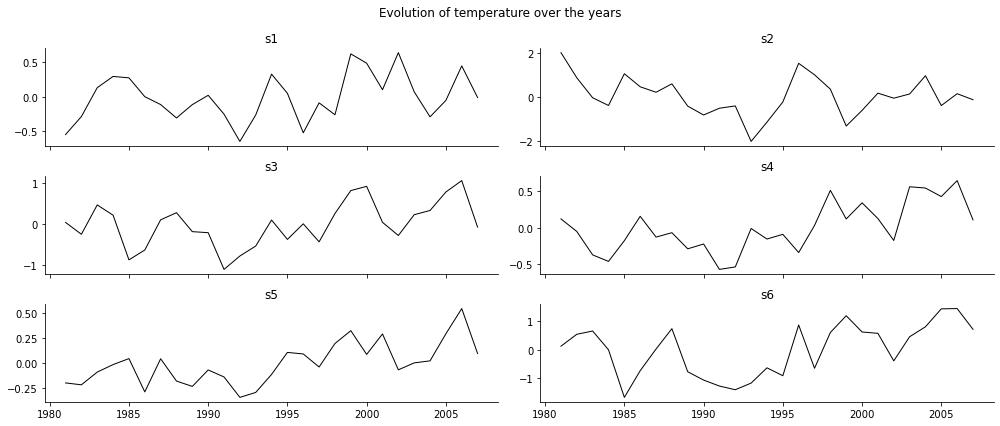

In [76]:
df_train['dates'] = pd.to_datetime(df_train['dates'])
m = df_train['dates'].dt.year
result = df.groupby(m).mean()
axes = result.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')
    
plt.suptitle('Evolution of temperature over the years')
plt.gcf().tight_layout()
sns.despine();

## Correlation

[Text(0.5, 1.0, 'Matrix of correlation of stations')]

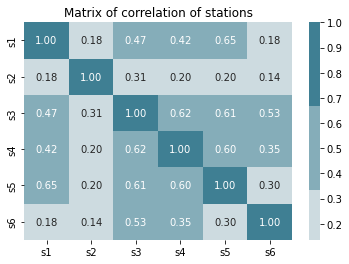

In [87]:
sns.heatmap(df_train.corr(), 
            fmt='.2f',
            annot=True,
            cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0).set(title='Matrix of correlation of stations')

## Normalize Data

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [8]:
scaled_data.shape

(9618, 6)

## Set up random series generator

In [9]:
data = []
for i in range(0,len(scaled_data) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [10]:
n_windows

6330

In [12]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [13]:
#noise = np.load(os.getcwd()+'/the_ginger_elephants-master/data/noise.npy')
#noise = np.load("./drive/MyDrive/Master Data Science - Polytechnique/MCMC/GenHack/data/noise.npy")
#noise = np.tile(noise,(192,1))
#noise = noise[:,:10]

noise = np.random.randn(seq_len, 50)
def make_random_data():
    while True:
        yield noise
        
# create 128 * noise shape (10,50)
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

##  Network Parameters

In [14]:
hidden_dim = 10
num_layers = 3

## Input place holders

In [15]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, 50], name='RandomData')

In [16]:
noise.shape

(3288, 50)

In [17]:
X,Z

(<KerasTensor: shape=(None, 3288, 6) dtype=float32 (created by layer 'RealData')>,
 <KerasTensor: shape=(None, 3288, 50) dtype=float32 (created by layer 'RandomData')>)

## RNN block generator

In [18]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [19]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [20]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [21]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [22]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [23]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [24]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 3288, 6)]         0         
                                                                 
 Embedder (Sequential)       (None, 3288, 10)          1970      
                                                                 
 Recovery (Sequential)       (None, 3288, 6)           2046      
                                                                 
Total params: 4,016
Trainable params: 4,016
Non-trainable params: 0
_________________________________________________________________


## Autoencoder Optimizer

In [25]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [26]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [30]:
#autoencoder = tf.keras.models.load_model('./drive/MyDrive/GenHack/saved_autoencoder/my_autoencoder')
autoencoder = tf.keras.models.load_model(os.getcwd()+'/parameters/parameters-genhack/saved_autoencoder/my_autoencoder')

## Autoencoder Training Loop

In [27]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)#real_test_1#next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    #with writer.as_default():
     #   tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [18:30:03<00:00,  6.66s/it] 


In [64]:
!mkdir -p saved_model
#autoencoder.save('./drive/MyDrive/GenHack/saved_autoencoder/my_autoencoder')
autoencoder.save(os.getcwd()+'/parameters/parameters-genhack/saved_autoencoder/my_autoencoder')

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_autoencoder/my_autoencoder/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_autoencoder/my_autoencoder/assets


# Phase 2: Supervised training

## Define Optimizer

In [28]:
supervisor_optimizer = Adam()

## Train Step

In [29]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [ ]:
supervisor = tf.keras.models.load_model(os.getcwd()+'/parameters/parameters-genhack/saved_supervisor/my_supervisor')

In [30]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)#real_test_1#next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    #with writer.as_default():
    #   tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [7:18:21<00:00,  2.63s/it] 


In [68]:
supervisor.save(os.getcwd()+'/parameters/parameters-genhack/saved_supervisor/my_supervisor')

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_supervisor/my_supervisor/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_supervisor/my_supervisor/assets


# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [31]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [32]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 3288, 50)]        0         
                                                                 
 Generator (Sequential)      (None, 3288, 10)          3290      
                                                                 
 Supervisor (Sequential)     (None, 3288, 10)          1430      
                                                                 
 Discriminator (Sequential)  (None, 3288, 1)           1991      
                                                                 
Total params: 6,711
Trainable params: 6,711
Non-trainable params: 0
_________________________________________________________________


### Adversarial Architecture in Latent Space

In [33]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [34]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 3288, 50)]        0         
                                                                 
 Generator (Sequential)      (None, 3288, 10)          3290      
                                                                 
 Discriminator (Sequential)  (None, 3288, 1)           1991      
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


### Mean & Variance Loss

In [35]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [36]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 3288, 50)]        0         
                                                                 
 Generator (Sequential)      (None, 3288, 10)          3290      
                                                                 
 Supervisor (Sequential)     (None, 3288, 10)          1430      
                                                                 
 Recovery (Sequential)       (None, 3288, 6)           2046      
                                                                 
Total params: 6,766
Trainable params: 6,766
Non-trainable params: 0
_________________________________________________________________


In [37]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [38]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [39]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 3288, 6)]         0         
                                                                 
 Embedder (Sequential)       (None, 3288, 10)          1970      
                                                                 
 Discriminator (Sequential)  (None, 3288, 1)           1991      
                                                                 
Total params: 3,961
Trainable params: 3,961
Non-trainable params: 0
_________________________________________________________________


## Optimizers

In [40]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [41]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss


## Embedding Train Step

In [42]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [43]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [44]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [ ]:
######## LOAD OPTIMIZER WEIGHTS #########

generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

opt_weights_generator = np.load('./drive/MyDrive/GenHack/my_generator_optimizer.npy', allow_pickle=True)
opt_weights_discriminator = np.load('./drive/MyDrive/GenHack/my_discriminator_optimizer.npy', allow_pickle=True)
opt_weights_embedding = np.load('./drive/MyDrive/GenHack/my_embedding_optimizer.npy', allow_pickle=True)




with tf.GradientTape() as tape:
    y_fake = adversarial_supervised(next(random_series))
    generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                      y_pred=y_fake)

    y_fake_e = adversarial_emb(next(random_series))
    generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                        y_pred=y_fake_e)
    h = embedder(next(real_series_iter))
    h_hat_supervised = supervisor(h)
    generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_hat = synthetic_data(next(random_series))
    generator_moment_loss = get_generator_moment_loss(next(real_series_iter), x_hat)

    generator_loss = (generator_loss_unsupervised +
                      generator_loss_unsupervised_e +
                      100 * tf.sqrt(generator_loss_supervised) +
                      100 * generator_moment_loss)

var_list = generator.trainable_variables + supervisor.trainable_variables
gradients = tape.gradient(generator_loss, var_list)
generator_optimizer.apply_gradients(zip(gradients, var_list))




train_discriminator(next(real_series_iter),next(random_series))




with tf.GradientTape() as tape:
    h = embedder(next(real_series_iter))
    h_hat_supervised = supervisor(h)
    generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_tilde = autoencoder(next(real_series_iter))
    embedding_loss_t0 = mse(next(real_series_iter), x_tilde)
    e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

var_list = embedder.trainable_variables + recovery.trainable_variables
gradients = tape.gradient(e_loss, var_list)
embedding_optimizer.apply_gradients(zip(gradients, var_list))
    
    
    
    
generator_optimizer.set_weights(opt_weights_generator)
discriminator_optimizer.set_weights(opt_weights_discriminator)
embedding_optimizer.set_weights(opt_weights_embedding)

In [46]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in tqdm(range(10000)):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
      X_ = next(real_series_iter)#real_test_1#next(real_series_iter)
      Z_ = next(random_series)#noise#next(random_series)

      # Train generator
      step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
      # Train embedder
      step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)#real_test_1#next(real_series_iter)
    Z_ = next(random_series)#noise#next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
      #!mkdir -p saved_model
      synthetic_data.save(os.getcwd()+'/parameters/parameters-genhack/saved_model/my_model')
      ######## SAVE OPTIMIZER WEIGHTS #########
     # np.save('./drive/MyDrive/GenHack/my_embedding_optimizer', embedding_optimizer.get_weights())
      #np.save('./drive/MyDrive/GenHack/my_discriminator_optimizer', discriminator_optimizer.get_weights())
      #np.save('./drive/MyDrive/GenHack/my_generator_optimizer', generator_optimizer.get_weights())
    
    #if step%2 == 0:
    #    print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
    #          f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    #with writer.as_default():
     #   tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
      #  tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
       # tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        #tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        #tf.summary.scalar('D Loss', step_d_loss, step=step)

  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 10%|█         | 1000/10000 [15:47:07<155:39:29, 62.26s/it]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 20%|██        | 2000/10000 [31:45:49<126:24:41, 56.89s/it]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 30%|███       | 3000/10000 [47:36:54<112:04:35, 57.64s/it]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 40%|████      | 4000/10000 [62:58:17<94:00:51, 56.41s/it] 

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 50%|█████     | 5000/10000 [79:00:43<80:57:32, 58.29s/it] 

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 60%|██████    | 6000/10000 [95:54:23<61:29:46, 55.35s/it] 

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 70%|███████   | 7000/10000 [111:36:02<54:30:35, 65.41s/it]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 80%|████████  | 8000/10000 [127:32:57<30:18:26, 54.55s/it]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
 90%|█████████ | 9000/10000 [143:43:11<16:06:45, 58.01s/it]

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets
100%|██████████| 10000/10000 [159:21:59<00:00, 57.37s/it]  


In [47]:
synthetic_data.save(os.getcwd()+'/parameters/parameters-genhack/saved_model/my_model')

INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /Users/pierreloviton/PycharmProjects/data-science/M2DS X/Monte Carlo Methods: from MCMC to Data-based Generative model/Gen Hack/the_ginger_elephants-master/parameters/parameters-genhack/saved_model/my_model/assets


# Generate Synthetic Data

In [50]:
generated_data = np.array(np.vstack(synthetic_data(next(random_series))))
generated_data.shape

(420864, 6)

## Rescale

In [51]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
generated_data.shape

(128, 3288, 6)

## Rescale

In [48]:
def AndersonDarling(data,predictions):
    N,P = data.shape
    ADdistance = 0
    for station in range(P) :
        temp_predictions = predictions[:,station].reshape(-1)
        temp_data = data[:,station].reshape(-1)
        sorted_array = np.sort(temp_predictions)
        count = np.zeros(len(temp_data))
        count = (1/(N+2)) * np.array([(temp_data < order).sum()+1 for order in sorted_array])
        idx = np.arange(1, N+1)
        ADdistance = (2*idx - 1) * (np.log(count) + np.log(1-count[::-1]))
        ADdistance = - N - np.sum(ADdistance)/N
    return ADdistance/P

In [59]:
df_test = pd.read_csv(os.getcwd()+'/data/df_test.csv')


In [62]:
df_test = df_test.drop('dates',1)

In [63]:
AndersonDarling(np.array(df_test), generated_data[0])

201.46447923043237

In [66]:
scipy.stats.kendalltau(np.array(df_test),generated_data[0])

KendalltauResult(correlation=0.038417421814713026, pvalue=5.810324347910279e-16)

## Plot sample Series

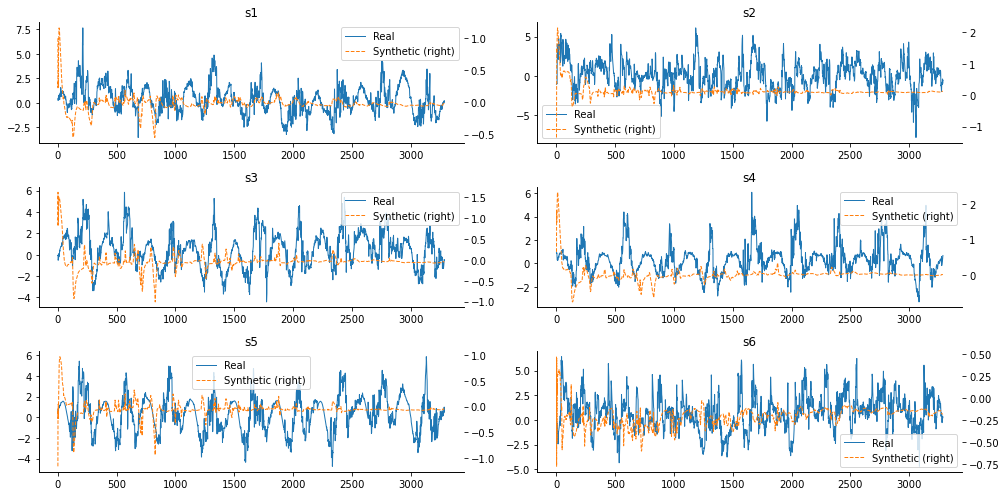

In [57]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[1]

idx = np.random.randint(len(df) - seq_len)
real = df[df.shape[0]-3288:]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

In [ ]:
AndersonDarling(np.array(df[:3288]), generated_data[0])

214.92867530791364

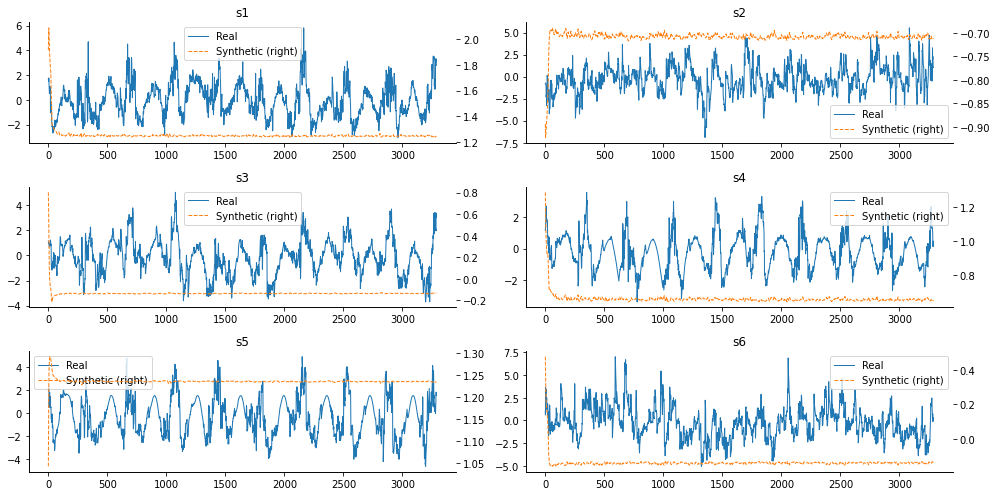

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[1]

idx = np.random.randint(len(df) - seq_len)
real = df[:3288]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()